In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cell 2: Read Data and Initial Cleaning
# Read data
df = pd.read_csv('used_car.csv')

# Split car names
def split_car_name(name):
    two_word_companies = ['Land Rover', 'Mercedes Benz', 'Maruti Suzuki', 
                         'Mercedes-Benz', 'Rolls Royce', 'Mini Cooper', 'MINI Cooper']
    name_parts = name.split()
    
    if ' '.join(name_parts[:2]) in two_word_companies:
        company = ' '.join(name_parts[:2])
        model = ' '.join(name_parts[2:])
    else:
        company = name_parts[0]
        model = ' '.join(name_parts[1:])
    
    return pd.Series([company, model], index=['company', 'model'])

df[['company', 'model']] = df['car_name'].apply(split_car_name)

In [3]:
# Cell 3: Clean Numerical Data
# Clean price
def clean_price(price_str):
    if isinstance(price_str, str):
        if 'Lakh' in price_str:
            price_str = price_str.replace('₹', '').replace('Lakh', '').strip()
            try:
                return float(price_str) * 100000
            except ValueError:
                return None
        elif 'Crore' in price_str:
            price_str = price_str.replace('₹', '').replace('Crore', '').strip()
            try:
                return float(price_str) * 10000000
            except ValueError:
                return None
    return price_str

df['car_price_in_rupees'] = df['car_price_in_rupees'].apply(clean_price)

# Clean kilometers driven
def clean_kms_driven(kms_driven_str):
    if isinstance(kms_driven_str, str):
        kms_driven_str = kms_driven_str.replace('km', '').replace(',', '').strip()
        try:
            return int(kms_driven_str)
        except ValueError:
            return None
    return kms_driven_str

df['kms_driven'] = df['kms_driven'].apply(clean_kms_driven)

# Calculate age
current_year = datetime.datetime.now().year
df['age'] = df['year_of_manufacture'].apply(lambda x: current_year - x)

In [4]:
# Cell 4: Remove Low Frequency Companies
# Count company frequencies
company_counts = df['company'].value_counts()
frequent_companies = company_counts[company_counts >= 15].index

# Filter dataframe
df = df[df['company'].isin(frequent_companies)]

print("Companies and their frequencies:")
print(company_counts[company_counts >= 15])

Companies and their frequencies:
company
Maruti Suzuki    567
Hyundai          443
Honda            225
Toyota            93
Tata              83
Mercedes-Benz     70
Ford              70
Renault           67
Mahindra          65
Volkswagen        63
Audi              62
BMW               56
Skoda             49
Kia               41
Jeep              30
MG                27
Land Rover        20
Nissan            18
Name: count, dtype: int64


In [6]:
# Cell 5: Remove Outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    
    # First convert columns to numeric and handle any non-numeric values
    for column in columns:
        df_clean[column] = pd.to_numeric(df_clean[column], errors='coerce')
    
    # Drop rows with NaN values after conversion
    df_clean = df_clean.dropna(subset=columns)
    
    # Now remove outliers
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[column] >= lower_bound) & 
            (df_clean[column] <= upper_bound)
        ]
    
    print(f"Rows remaining after cleaning {column}: {len(df_clean)}")
    return df_clean

# Remove outliers from numerical columns
numerical_columns = ['car_price_in_rupees', 'kms_driven', 'age']
df = remove_outliers(df, numerical_columns)

print("\nFinal shape after removing outliers:", df.shape)

Rows remaining after cleaning age: 1781

Final shape after removing outliers: (1781, 9)


In [7]:
# Cell 6: Feature Engineering
# Create interaction features
df['price_per_km'] = df['car_price_in_rupees'] / (df['kms_driven'] + 1)
df['price_per_year'] = df['car_price_in_rupees'] / (df['age'] + 1)
df['km_per_year'] = df['kms_driven'] / (df['age'] + 1)

# Create categorical features
df['price_segment'] = pd.qcut(df['car_price_in_rupees'], q=5, 
                            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df['age_category'] = pd.cut(df['age'], 
                          bins=[0, 3, 6, 9, 12, float('inf')],
                          labels=['New', 'Slightly Used', 'Used', 'Old', 'Very Old'])


Columns in X: ['car_name', 'kms_driven', 'fuel_type', 'city', 'year_of_manufacture', 'company', 'model', 'age', 'price_per_km', 'price_per_year', 'km_per_year', 'price_segment', 'age_category']

Datatypes of columns:
car_name                 int32
kms_driven               int64
fuel_type                int32
city                     int32
year_of_manufacture      int64
company                  int32
model                    int32
age                      int64
price_per_km           float64
price_per_year         float64
km_per_year            float64
price_segment            int32
age_category             int32
dtype: object


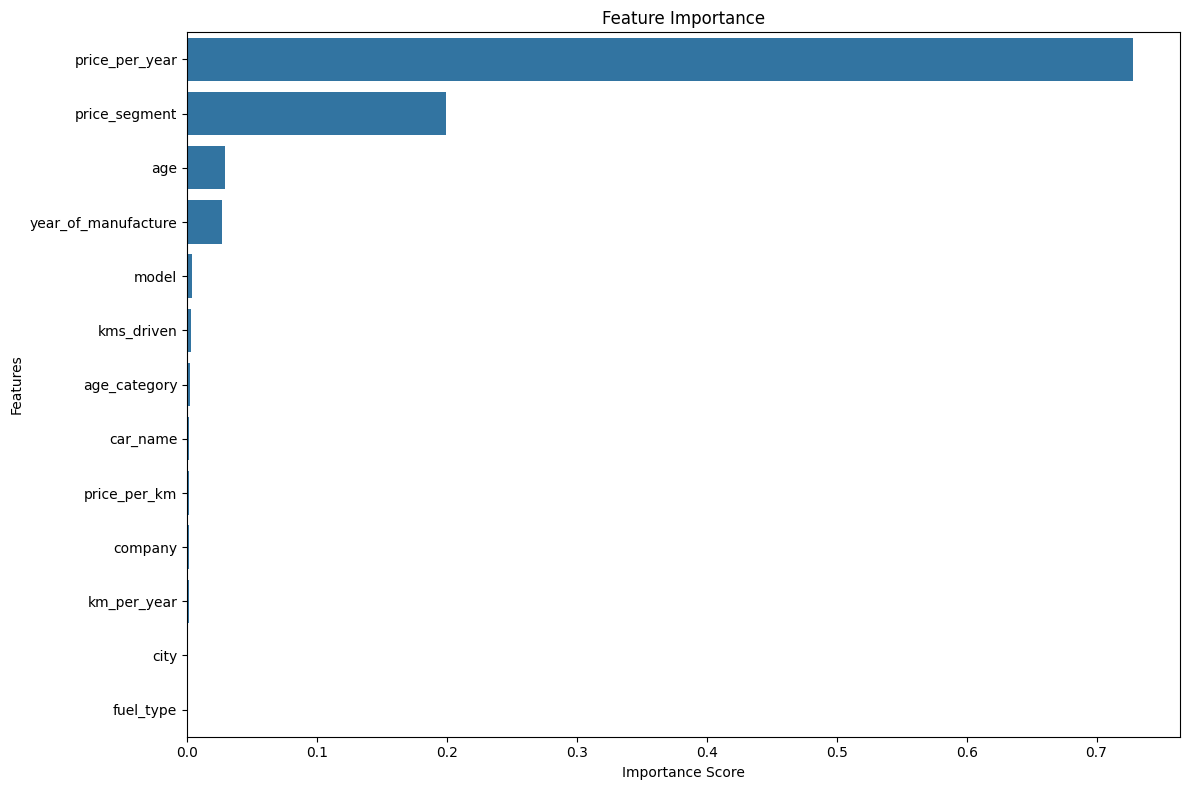


Selected features:
1. price_per_year
2. price_segment


In [9]:
# Cell 7: Feature Selection using Random Forest
# Prepare data for feature importance
X = df.drop(['car_price_in_rupees'], axis=1)  # Only drop the target variable
y = df['car_price_in_rupees']

# Convert categorical variables to numeric
categorical_columns = X.select_dtypes(include=['object', 'category']).columns  # Include category dtype
for col in categorical_columns:
    try:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))  # Convert to string first
    except Exception as e:
        print(f"Error encoding column {col}: {str(e)}")
        print(f"Unique values in {col}:", X[col].unique())

# Print column information for debugging
print("\nColumns in X:", X.columns.tolist())
print("\nDatatypes of columns:")
print(X.dtypes)

# Train Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Select top features (e.g., top 80% of cumulative importance)
cumsum = np.cumsum(feature_importance['importance'])
n_features = np.argmax(cumsum >= 0.8) + 1
selected_features = feature_importance['feature'].iloc[:n_features].tolist()

print("\nSelected features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

In [10]:
# Cell 8: Prepare Final Dataset
# Keep only selected features and target variable
final_features = selected_features + ['car_price_in_rupees']
df_final = df[final_features]

# Check final dataset
print("\nFinal dataset shape:", df_final.shape)
print("\nFinal features:", df_final.columns.tolist())

# Save cleaned dataset
df_final.to_csv('cleaned_car_data.csv', index=False)


Final dataset shape: (1781, 3)

Final features: ['price_per_year', 'price_segment', 'car_price_in_rupees']
